# 6章 効果検証 のサンプルコード

Author: hagino3000  
Date: 2017-10-05

In [1]:
%matplotlib inline
#日本語使える。高解像になる。
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'AppleGothic'
# import matplotlib.font_manager as fm
# print(fm.findSystemFonts())
#scipyの統計
import scipy.stats

# コインは歪んでるか

コイントスをするゲーム。直近 20 回の記録では表が 15 回、裏が 5 回出ている。    
まずは50% で表の出るコインを 20 回トスした時の結果の分布を見てみる。二項分布 Bin(20, 0.5) であることから次のコードで確率分布の形状が見られます。    
試行回数の丁度半分の10回 表が出る確率が最も高いのがわかる。

In [47]:
x = np.arange(0, 21)
y = scipy.stats.binom.pmf(x, 20, 0.5)

Text(0,0.5,'確率')

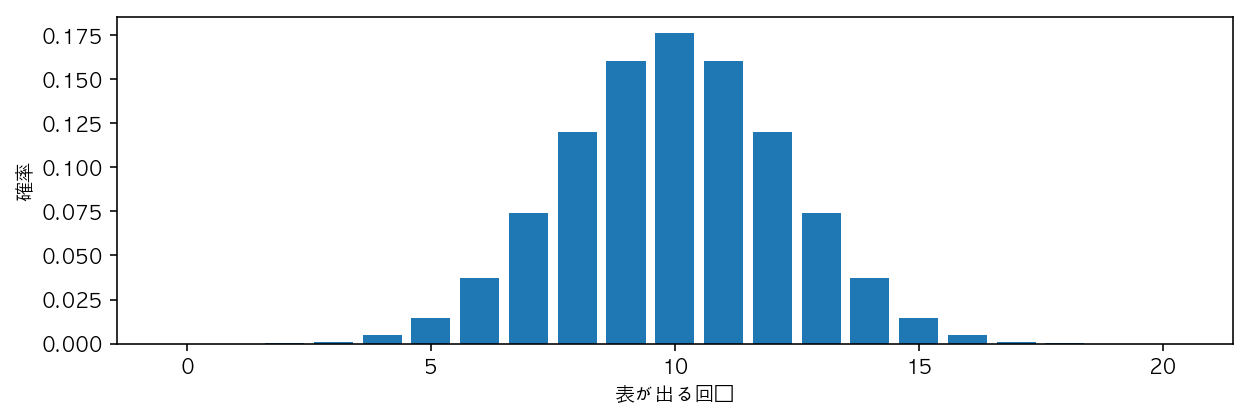

In [48]:
plt.figure(figsize=(10, 3))
plt.bar(x, y)
plt.xlabel('表が出る回数')
plt.ylabel('確率')

表が出る確率が 50% の時に 20 回のコイントスで表が出る 回数の分布。

In [49]:
import pandas as pd
p_value = pd.DataFrame({'表の出る回数':x, '確率': y}).query(
    '表の出る回数 >= 15'
)['確率'].sum()
print(p_value)

0.02069473266601554


In [51]:
import pandas as pd
p_value = pd.DataFrame({'表の出る回数':x, '確率': y}).query('表の出る回数 >= 15')['確率'].sum()
print('{:,.4f}'.format(p_value))
print('{:,.2f}'.format(p_value))
#4f四捨五入

0.0207
0.02


分布の裾に着目すると 15 回以上表が出る確率は2%にすぎないので、何か細工があるのではないかと考えるのが検定の考え方。
    
帰無仮説：検定を行うため立てる仮説のこと    
対立仮説：帰無仮説に対する仮説のこと    
    
今回の例でいうと表が出る確率は50%であるとした仮説を帰無仮説。    
表が出る確率は50%と異なるとする仮説を対立仮説。    
帰無仮 説が真であるとした時の確率を p 値(p-value)。    
p 値の閾値、例えば「5% より低いことが起 きていたら帰無仮説を棄却すると」と判断する値を有意水準(Significant Level)

# 二群の母比率の差の検定

 EC サイトを運営していて、集客のために広告を出稿するとします。    
 

In [52]:
# テストデータ。継続化人数, 離脱人数
a = [40, 165]
b = [62, 228]

In [53]:
print('Sample A: size={}, converted={}, mean={:.3f}'.format(sum(a), a[0], a[0]/sum(a)))
print('Sample B: size={}, converted={}, mean={:.3f}'.format(sum(b), b[0], b[0]/sum(b)))

Sample A: size=205, converted=40, mean=0.195
Sample B: size=290, converted=62, mean=0.214


In [57]:
x = np.linspace(0, 1, 200)

# 流入元がAのサンプル
n = sum(a)
p = a[0]/n
std = np.sqrt(p*(1-p)/n)
#確率密度関数norm.pdf
y_a = scipy.stats.norm.pdf(x, p, std)

# 流入元がBのサンプル
n = sum(b)
p = b[0]/n
std = np.sqrt(p*(1-p)/n)
#確率密度関数norm.pdf
y_b = scipy.stats.norm.pdf(x, p, std)

Text(0,0.5,'尤度')

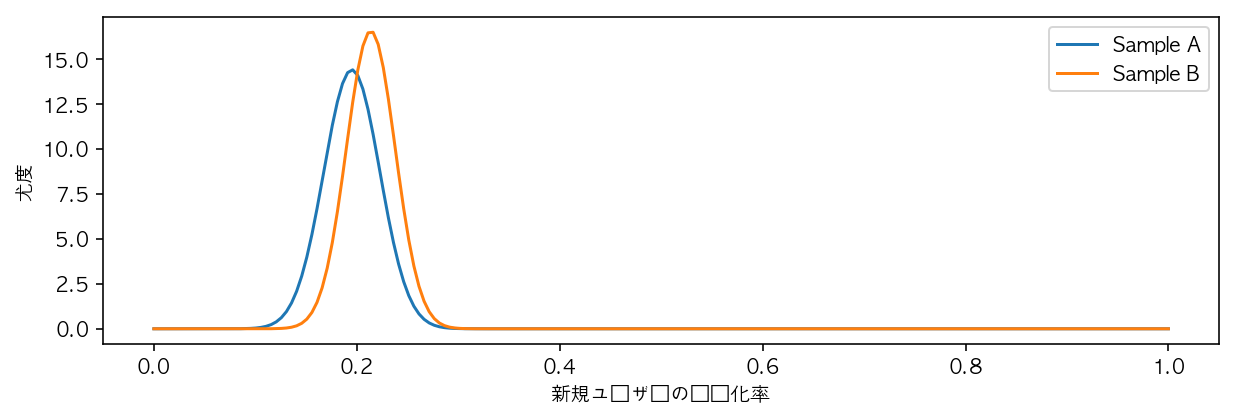

In [55]:
plt.figure(figsize=(10, 3))
plt.plot(x, y_a, label='Sample A')
plt.plot(x, y_b, label='Sample B')
plt.legend(loc='best')
plt.xlabel('新規ユーザーの継続化率')
plt.ylabel('尤度')

流入経路別ユーザーの継続化率の推定値    
B の方が良さそうに見えますが、誤差なのか判断できません

In [11]:
print(scipy.stats.chi2_contingency.__doc__)

Chi-square test of independence of variables in a contingency table.

    This function computes the chi-square statistic and p-value for the
    hypothesis test of independence of the observed frequencies in the
    contingency table [1]_ `observed`.  The expected frequencies are computed
    based on the marginal sums under the assumption of independence; see
    `scipy.stats.contingency.expected_freq`.  The number of degrees of
    freedom is (expressed using numpy functions and attributes)::

        dof = observed.size - sum(observed.shape) + observed.ndim - 1


    Parameters
    ----------
    observed : array_like
        The contingency table. The table contains the observed frequencies
        (i.e. number of occurrences) in each category.  In the two-dimensional
        case, the table is often described as an "R x C table".
    correction : bool, optional
        If True, *and* the degrees of freedom is 1, apply Yates' correction
        for continuity.  The effect of the c

仮説検定の枠組みを適用してみる。カイ二乗検定をかける。

In [60]:
#継続化人数, 離脱人数
print("a", a)
print("b", b)
# カイ二乗検定
_, p_value, _, _ = scipy.stats.chi2_contingency([a, b])
print(p_value)

a [40, 165]
b [62, 228]
0.694254736449269


p値は 0.69で有意水準は 0.05 なので、帰無仮説が棄却できない。

信頼区間の幅がほぼ重複していることから、差があると言えないのは違和 感の無い結果とのこと。    


# 繰り返し検定をしてしまう

仮説検定では標本は固定すること。    
もし帰無仮説が真の状況で 1 回投げる毎に検定をした場合。

In [61]:
np.random.seed(34)

In [62]:
mu = 0.5 # 表が出る確率50%
#ベルヌーイ分布生成
init_sample = list(scipy.stats.bernoulli.rvs(mu, size=20))

sample = init_sample
p_value_history = []
for i in range(200):
    # 直近20回の結果を使って検定(ttest_1samp：1標本t検定)
    _, p_value = scipy.stats.ttest_1samp(sample[-20:], 0.5)
    p_value_history.append(p_value)
    # 新たにコインを投げて結果を保持
    sample.append(scipy.stats.bernoulli.rvs(mu))

Text(0,0.5,'p値')

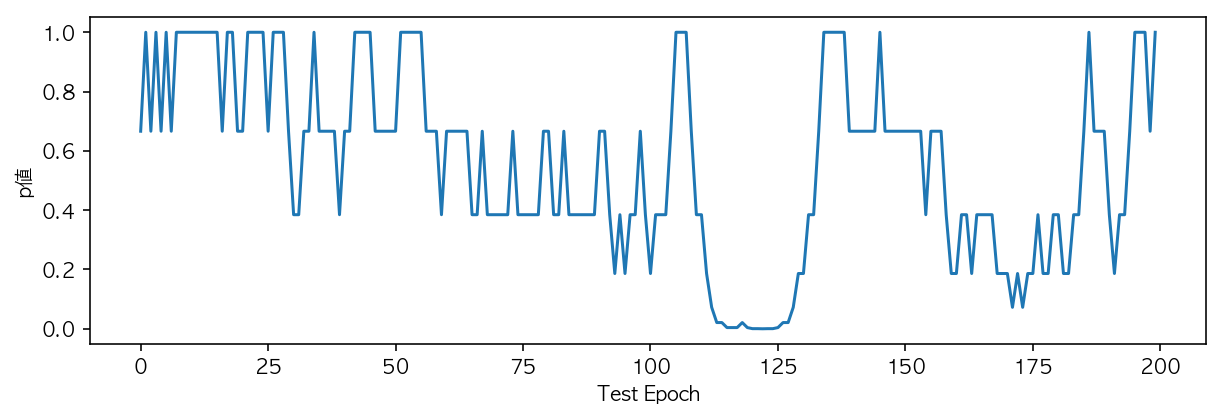

In [63]:
plt.figure(figsize=(10, 3))
plt.plot(p_value_history)
plt.xlabel('Test Epoch')
plt.ylabel('p値')

コイン投げ 1 回毎に検定をした場合の p 値の推移    
120 回目付近の p 値が 0.05 以下になってる。都合のいいところで止めることができる。


# 有意差とビジネスインパクト

平均に 0.1% の差のある 2 群を2標本t検定:ttest_indで比較

In [4]:
np.random.seed(31)
max_sample = 3000000
# サンプルA 平均:45.1%
a = scipy.stats.bernoulli.rvs(0.451, size=max_sample)
# サンプルB 平均:45.2%
b = scipy.stats.bernoulli.rvs(0.452, size=max_sample)
p_values = []
# 5000づつサンプルサイズを増やして検定を行なう
sample_sizes = np.arange(1000, max_sample, 5000)
for sample_size in sample_sizes:
    #2標本t検定:ttest_ind
    _, p_value = scipy.stats.ttest_ind(a[:sample_size], b[:sample_size], equal_var=False)
    p_values.append(p_value)

Text(0,0.5,'p値')

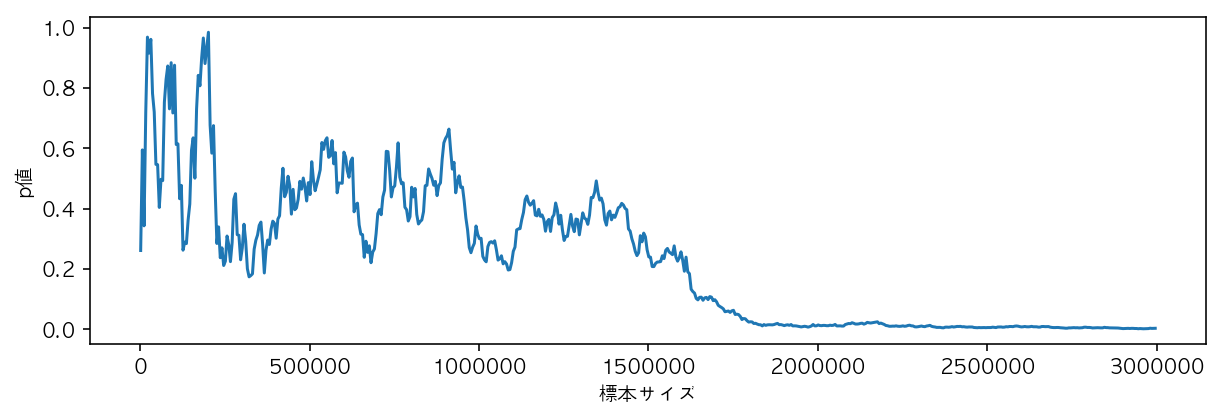

In [5]:
plt.figure(figsize=(10, 3))
plt.plot(sample_sizes, p_values)
plt.xlabel('標本サイズ')
plt.ylabel('p値')

標本サイズを増やしていった時の p 値の変化    
標本サイズが 170 万を越えたあたりで p 値がゼロに近づく。


In [6]:
#簡単に母平均の違いを見るのには信頼区間をプロットする方法がおすすめ
from statsmodels.stats.proportion import proportion_confint

# Wilson Score Intervalを利用して95%信頼区間を求める
a_lower, a_upper = proportion_confint(sum(a), len(a), alpha=0.05, method='wilson')
b_lower, b_upper = proportion_confint(sum(b), len(b), alpha=0.05, method='wilson')

Text(0,0.5,'母平均')

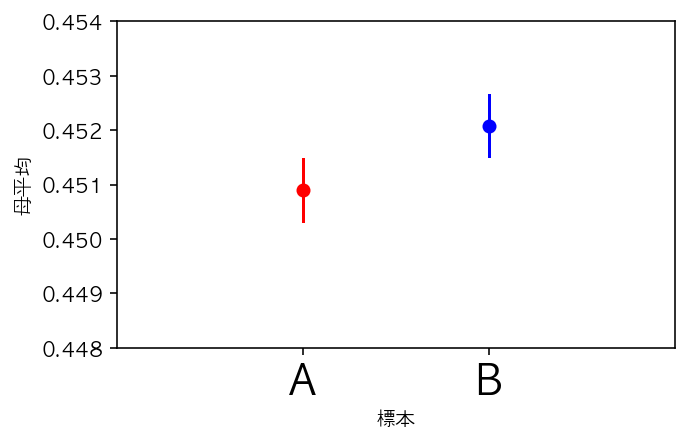

In [7]:
plt.figure(figsize=(5, 3))
plt.plot(1, np.mean(a), 'ro')
plt.plot(2, np.mean(b), 'bo')
plt.plot([1, 1], [a_lower, a_upper], 'r-')
plt.plot([2, 2], [b_lower, b_upper], 'b-')
plt.ylim(0.448, 0.454)
plt.xlim(0, 3)
plt.xticks([1, 2], ['A','B'], fontsize=20)
plt.xlabel('標本')
plt.ylabel('母平均')

95% 信頼区間のプロット。信頼区間が分離しているため違いがある事は分かるが、差は 0.001 程度である

# 複数の検定を同時に行う

複数の仮説にそれぞれ検定をすることを多重検定という。    
M個の仮説を有意水準αで検定をすると誤って１つでも帰無仮説を棄却する確率は

$$1-(1-α)^M$$

αが0.05と0.01をプロット

Text(0,0.5,'誤った発見をする確率')

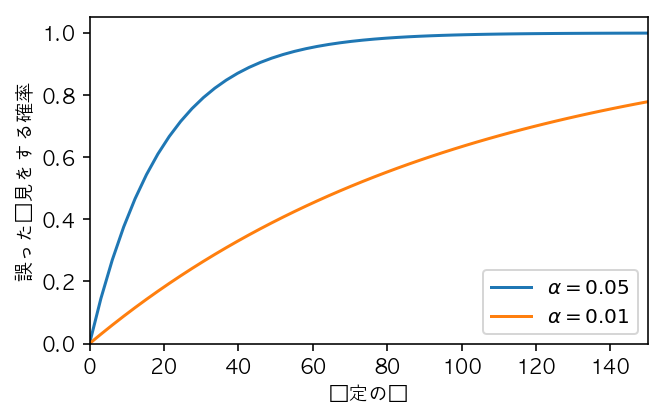

In [8]:
plt.figure(figsize=(5, 3))
x = np.linspace(0, 150)
plt.plot(x, 1 - (1 - 0.05)**x, label=r'$\alpha=0.05$')
plt.plot(x, 1 - (1 - 0.01)**x, label=r'$\alpha=0.01$')
plt.legend(loc='best')
plt.ylim(0, 1.05)
plt.xlim(0, 150)
plt.xlabel('検定の数')
plt.ylabel('誤った発見をする確率')

# 因果効果の推定

Web サービスの売上向上施策 X をリリースした時のサービスのユーザー 1 人あたりの売上の変化を
考えます。

In [12]:
import datetime as dt
import pandas as pd

In [13]:
x = pd.date_range(dt.datetime(2017, 3, 1), dt.datetime(2017, 4, 1))
y = np.random.randn(len(x)) * 20 + 1000
y2 = np.random.randn(len(x)) * 20 + 1000

In [14]:
y_change = list(np.zeros(int(len(x)/2))) + list(np.ones(int(len(x)/2)) + 200)

In [15]:
y_change2 = list(np.zeros(int(len(x)/2))) + list(np.ones(int(len(x)/2)).cumsum() * 7)

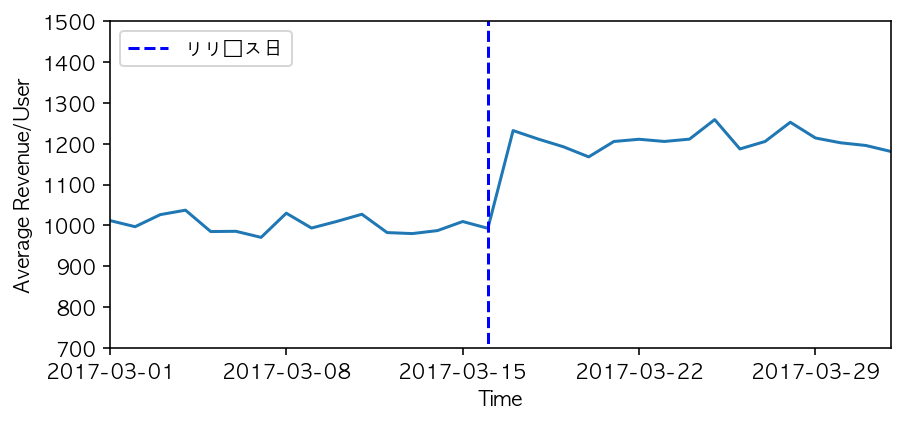

In [16]:
plt.figure(figsize=(7, 3))
plt.plot(x, y + y_change)
plt.ylim(700, 1500)
plt.xlabel('Time')
plt.xlim(x[0], x[-1])
plt.ylabel('Average Revenue/User')
plt.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--', label='リリース日')
plt.legend(loc='upper left')

このように施策を検証したくても検証しきれない。広告では売上 / 粗利の時系列は強い季節性を持っており広告主の予算 消化時期にピークがある。広告主の広告予算や配信先メディアの状況に強く影響を受けるた め、時間経過によって刻々と非連続な変化をする。

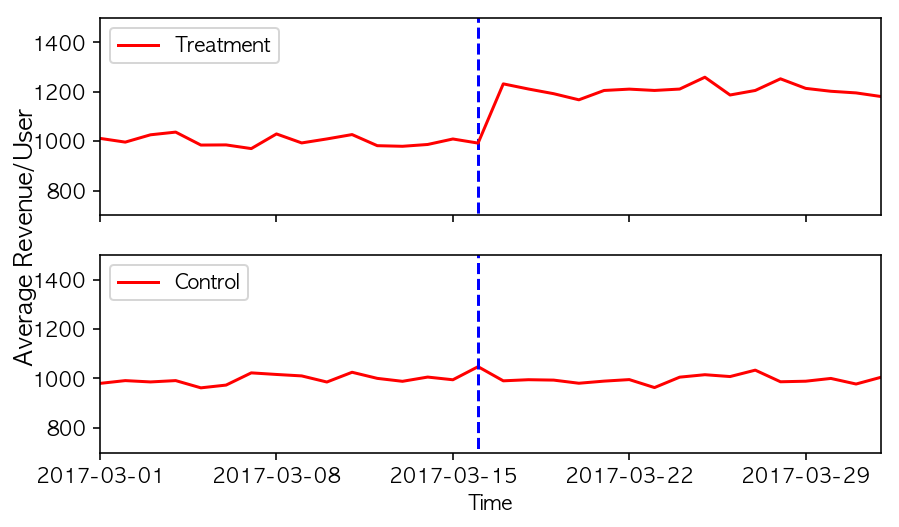

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7, 4))
ax1.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--')
ax1.plot(x, y + y_change, 'r-', label='Treatment')
ax1.set_ylim(700, 1500)
ax2.plot(x, y2, 'r-', label='Control')
ax1.legend(loc='upper left')
ax2.plot([dt.datetime(2017,3,16), dt.datetime(2017,3,16)], [0, 2000], 'b--')
ax2.set_ylim(700, 1500)
plt.xlabel('Time')
ax1.set_xlim(x[0], x[-1])
ax2.set_xlim(x[0], x[-1])
fig.text(0.04, 0.5, 'Average Revenue/User', va='center', rotation='vertical', fontsize=12)
plt.legend(loc='upper left')